# references
1. https://www.kaggle.com/columbia2131/device-eda-interpolate-by-removing-device-en-ja

# Load Libraries

In [1]:
import numpy as np
import pandas as pd
from glob import glob
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pathlib import Path
import plotly.express as px

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [2]:
%%javascript
IPython.notebook.kernel.execute(`notebookName = '${window.document.getElementById("notebook_name").innerHTML}'`);

<IPython.core.display.Javascript object>

In [3]:
%%javascript
IPython.notebook.kernel.execute(`notebookName = '${window.document.getElementById("notebook_name").innerHTML}'`);

<IPython.core.display.Javascript object>

In [7]:
%%javascript
IPython.notebook.kernel.execute(`notebookName = '${window.document.getElementById("notebook_name").innerHTML}'`);

<IPython.core.display.Javascript object>

In [8]:
print(notebookName)
PATH = Path(f"./models/{notebookName}")

Baseline


In [9]:
if os.path.isdir(PATH):
    dir_list = os.listdir(PATH)
    num_files = 0
    while True:
        if os.path.isfile(str(PATH / f"{num_files}")):
            print(num_files)
            num_files += 1
        else:
            break
else:
    os.mkdir(PATH)
    num_files = 0

0


In [10]:
num_files

1

In [11]:
RANDOM_STATE = 1990
lr = 0.001
batch_size = 64
EPOCH_NUM = 100

torch.manual_seed(RANDOM_STATE)

experience_name = f"{num_files}"
checkpoint_name = "check_point"
model_name = str("model - " + experience_name)
param_name = str("param - " + experience_name)
result_name = str("result - " + experience_name)

dummy_path = str(PATH / f"{num_files}")
checkpoint_path = str(PATH / f"{checkpoint_name}.pth")
model_path = str(PATH / f"{model_name}.pth")
param_path = str(PATH / f"{param_name}.pth")
result_path = str(PATH / f"{result_name}.csv")
model_path, param_path, result_path

('models\\Baseline\\model - 1.pth',
 'models\\Baseline\\param - 1.pth',
 'models\\Baseline\\result - 1.csv')

# Useful Functions

In [12]:
def get_groundtruth(path: Path) -> pd.DataFrame:
    output_df = pd.DataFrame()
    
    for path in glob(str(path / 'train/*/*/ground_truth.csv')):
        _df = pd.read_csv(path)
        output_df = pd.concat([output_df, _df])
    output_df = output_df.reset_index(drop=True)
    
    _columns = ['latDeg', 'lngDeg', 'heightAboveWgs84EllipsoidM']
    output_df[['t_'+col for col in _columns]] = output_df[_columns]
    output_df = output_df.drop(columns=_columns, axis=1)
    return output_df

In [42]:
def get_addtional_data(path: Path, train = True) ->pd.DataFrame:
    output_df = pd.DataFrame()
    
    if train:
        add_path = 'train/*/*/*derived.csv'
    else:
        add_path = 'test/*/*/*derived.csv'
            
    for path in glob(str(path / add_path)):
        _df = pd.read_csv(path)
        output_df = pd.concat([output_df, _df])
    output_df = output_df.reset_index(drop = True)
    
    return output_df

In [13]:
def calc_haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2
    
    c = 2 * np.arcsin(a ** 0.5)
    dist = 6_367_000 * c
    return dist

In [14]:
def check_score(input_df: pd.DataFrame) -> pd.DataFrame:
    output_df = input_df.copy()
    
    output_df['meter'] = input_df.apply(
        lambda r: calc_haversine(
            r.latDeg, r.lngDeg, r.t_latDeg, r.t_lngDeg
        ),
        axis=1
    )

    meter_score = output_df['meter'].mean()
    print(f'error meter: {meter_score}')

    scores = []
    for phone in output_df['phone'].unique():
        _index = output_df['phone']==phone
        p_50 = np.percentile(output_df.loc[_index, 'meter'], 50)
        p_95 = np.percentile(output_df.loc[_index, 'meter'], 95)
        scores.append(p_50)
        scores.append(p_95)

    score = sum(scores) / len(scores)
    print(f'score: {score}')
    
    return output_df, meter_score , score

In [15]:
def check_score_np(predict:torch.Tensor, target:torch.Tensor):
    m = []
    predict = predict.detach().numpy()
    target = target.detach().numpy()
    for i in range(predict.shape[0]):
        temp = calc_haversine(predict[i,0], predict[i,1], target[i,0], target[i,1])
        m.append(temp)
    
    m = np.array(m)
    score = (np.percentile(m, 50) + np.percentile(m, 95))/2
    
    return score

# Load Datasets

In [44]:
data_dir = Path("../input/google-smartphone-decimeter-challenge")
train_df = pd.read_csv(data_dir / "baseline_locations_train.csv")
train_add_df = get_addtional_data(data_dir, train = True)
test_df = pd.read_csv(data_dir / "baseline_locations_test.csv")
test_add_df = get_addtional_data(data_dir, train = False)

# merge graoundtruth
train_df = train_df.merge(
    get_groundtruth(data_dir),
    on=['collectionName', 'phoneName', 'millisSinceGpsEpoch']
)
train_df = train_df.merge(
    train_add_df,
    on=['collectionName', 'phoneName', 'millisSinceGpsEpoch']
)
test_df = test_df.merge(
    test_add_df,
    on=['collectionName', 'phoneName', 'millisSinceGpsEpoch']
)

,collectionName,phoneName,millisSinceGpsEpoch,constellationType,svid,signalType,receivedSvTimeInGpsNanos,xSatPosM,ySatPosM,zSatPosM,xSatVelMps,ySatVelMps,zSatVelMps,satClkBiasM,satClkDriftMps,rawPrM,rawPrUncM,isrbM,ionoDelayM,tropoDelayM
0,2020-05-14-US-MTV-1,Pixel4,1273529464442,3,24,GLO_G1,1273529463363061857,-2.539901e+07,-6.925122e+05,-2.280430e+06,-325.826,156.040,3559.757,-468.084,0.001,2.379498e+07,11.992,1134.758,10.866,16.647
1,2020-05-14-US-MTV-1,Pixel4,1273529464442,6,13,GAL_E1,1273529463363970742,-5.199894e+06,-1.741927e+07,2.336128e+07,2239.305,700.815,1022.014,120171.076,0.000,2.352251e+07,1.799,-222.675,3.946,2.717
2,2020-05-14-US-MTV-1,Pixel4,1273529464442,1,5,GPS_L1,1273529463365539137,-2.179863e+06,-2.615488e+07,-3.437694e+06,325.541,-419.725,3129.012,-3793.067,-0.001,2.305231e+07,4.197,0.000,7.554,5.704
3,2020-05-14-US-MTV-1,Pixel4,1273529464442,6,15,GAL_E1,1273529463352380595,1.635469e+07,-1.047833e+07,2.234460e+07,2172.409,561.971,-1326.001,259937.286,-0.000,2.699715e+07,8.094,-222.675,7.968,9.151
4,2020-05-14-US-MTV-1,Pixel4,1273529464442,6,21,GAL_E1,1273529463364075083,-1.484042e+07,-2.110960e+07,1.449632e+07,-426.094,-1395.675,-2467.793,-179555.991,-0.001,2.349123e+07,2.698,-222.675,3.834,2.544


In [17]:
# check score
train_df, default_loss, default_meas = check_score(train_df)

error meter: 3.846848374990639
score: 5.287970649084159


# Feature Engineering
## Simple view, what is in data frame.

In [45]:
print(train_df.shape)
train_df.head()

(2207029, 32)


,collectionName,phoneName,millisSinceGpsEpoch,latDeg,lngDeg,heightAboveWgs84EllipsoidM,phone,timeSinceFirstFixSeconds,hDop,vDop,...,xSatVelMps,ySatVelMps,zSatVelMps,satClkBiasM,satClkDriftMps,rawPrM,rawPrUncM,isrbM,ionoDelayM,tropoDelayM
0,2020-05-14-US-MTV-1,Pixel4,1273529464442,37.423578,-122.094101,-33.29,2020-05-14-US-MTV-1_Pixel4,552.44,1.1,0.0,...,-325.826,156.040,3559.757,-468.084,0.001,2.379498e+07,11.992,1134.758,10.866,16.647
1,2020-05-14-US-MTV-1,Pixel4,1273529464442,37.423578,-122.094101,-33.29,2020-05-14-US-MTV-1_Pixel4,552.44,1.1,0.0,...,2239.305,700.815,1022.014,120171.076,0.000,2.352251e+07,1.799,-222.675,3.946,2.717
2,2020-05-14-US-MTV-1,Pixel4,1273529464442,37.423578,-122.094101,-33.29,2020-05-14-US-MTV-1_Pixel4,552.44,1.1,0.0,...,325.541,-419.725,3129.012,-3793.067,-0.001,2.305231e+07,4.197,0.000,7.554,5.704
3,2020-05-14-US-MTV-1,Pixel4,1273529464442,37.423578,-122.094101,-33.29,2020-05-14-US-MTV-1_Pixel4,552.44,1.1,0.0,...,2172.409,561.971,-1326.001,259937.286,-0.000,2.699715e+07,8.094,-222.675,7.968,9.151
4,2020-05-14-US-MTV-1,Pixel4,1273529464442,37.423578,-122.094101,-33.29,2020-05-14-US-MTV-1_Pixel4,552.44,1.1,0.0,...,-426.094,-1395.675,-2467.793,-179555.991,-0.001,2.349123e+07,2.698,-222.675,3.834,2.544


In [46]:
print(test_df.shape)
test_df.head()

(1398289, 24)


,collectionName,phoneName,millisSinceGpsEpoch,latDeg,lngDeg,heightAboveWgs84EllipsoidM,phone,constellationType,svid,signalType,...,xSatVelMps,ySatVelMps,zSatVelMps,satClkBiasM,satClkDriftMps,rawPrM,rawPrUncM,isrbM,ionoDelayM,tropoDelayM
0,2020-05-15-US-MTV-1,Pixel4,1273608801654,37.416566,-122.082111,-27.75,2020-05-15-US-MTV-1_Pixel4,1,2,GPS_L1,...,302.889,-47.613,3160.562,-136834.396,-0.002,2.175749e+07,3.598,0.000,4.784,3.446
1,2020-05-15-US-MTV-1,Pixel4,1273608801654,37.416566,-122.082111,-27.75,2020-05-15-US-MTV-1_Pixel4,1,6,GPS_L1,...,823.829,1072.241,2823.713,-81575.055,-0.002,2.086392e+07,2.998,0.000,3.944,2.849
2,2020-05-15-US-MTV-1,Pixel4,1273608801654,37.416566,-122.082111,-27.75,2020-05-15-US-MTV-1_Pixel4,6,25,GAL_E1,...,23.951,-536.768,-2983.575,-153084.743,-0.000,2.569017e+07,2.398,-216.118,5.918,4.439
3,2020-05-15-US-MTV-1,Pixel4,1273608801654,37.416566,-122.082111,-27.75,2020-05-15-US-MTV-1_Pixel4,1,17,GPS_L1,...,2640.705,239.526,-798.715,79526.801,0.003,2.268504e+07,1.799,0.000,5.496,4.392
4,2020-05-15-US-MTV-1,Pixel4,1273608801654,37.416566,-122.082111,-27.75,2020-05-15-US-MTV-1_Pixel4,3,22,GLO_G1,...,2429.314,1613.344,1483.924,-418.462,-0.001,1.972285e+07,4.797,1144.294,3.714,2.857


In [49]:
print(train_df.columns)
print(test_df.columns)
print(set(train_df.columns) - set(test_df.columns))
print(set(train_df.columns) and set(test_df.columns))

Index(['collectionName', 'phoneName', 'millisSinceGpsEpoch', 'latDeg',
       'lngDeg', 'heightAboveWgs84EllipsoidM', 'phone',
       'timeSinceFirstFixSeconds', 'hDop', 'vDop', 'speedMps', 'courseDegree',
       't_latDeg', 't_lngDeg', 't_heightAboveWgs84EllipsoidM',
       'constellationType', 'svid', 'signalType', 'receivedSvTimeInGpsNanos',
       'xSatPosM', 'ySatPosM', 'zSatPosM', 'xSatVelMps', 'ySatVelMps',
       'zSatVelMps', 'satClkBiasM', 'satClkDriftMps', 'rawPrM', 'rawPrUncM',
       'isrbM', 'ionoDelayM', 'tropoDelayM'],
      dtype='object')
Index(['collectionName', 'phoneName', 'millisSinceGpsEpoch', 'latDeg',
       'lngDeg', 'heightAboveWgs84EllipsoidM', 'phone', 'constellationType',
       'svid', 'signalType', 'receivedSvTimeInGpsNanos', 'xSatPosM',
       'ySatPosM', 'zSatPosM', 'xSatVelMps', 'ySatVelMps', 'zSatVelMps',
       'satClkBiasM', 'satClkDriftMps', 'rawPrM', 'rawPrUncM', 'isrbM',
       'ionoDelayM', 'tropoDelayM'],
      dtype='object')
{'speedMps', 'co

## signalType

In [51]:
train_df['signalType'].value_counts()

GPS_L1     666959
GAL_E1     417448
GLO_G1     392574
GAL_E5A    290413
BDS_B1I    227752
GPS_L5     185206
QZS_J1      17237
QZS_J5       9440
Name: signalType, dtype: int64

In [20]:
def extract_features(df, train = True):
    Xcols = ['latDeg', 'lngDeg', 'heightAboveWgs84EllipsoidM']
    Ycols = ['t_latDeg', 't_lngDeg', 't_heightAboveWgs84EllipsoidM']
    
    X = df[Xcols]
    if train:
        y = df[Ycols]
    else:
        y = None
    
    return np.array(X), np.array(y)

X, y = extract_features(train_df)

print(X.shape, y.shape)

(131342, 3) (131342, 3)


# Modeling

In [21]:
# build model
class SimpleNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 256)
        self.fc5 = nn.Linear(256, output_size)
        
        self.dropout_30 = nn.Dropout(p = 0.3)
        self.dropout_60 = nn.Dropout(p = 0.6)
    
    def forward(self, x):
        x =  F.relu(self.fc1(x))
        x = self.dropout_60(x)
        x =  F.relu(self.fc2(x))
        x = self.dropout_60(x)
        x =  F.relu(self.fc3(x))
        x = self.dropout_30(x)
        x =  F.relu(self.fc4(x))
        x = self.dropout_30(x)
        x = self.fc5(x)
        
        return x
    
model = SimpleNetwork(len(colNames[0]), len(colNames[1]))
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = lr)

In [22]:
# Create DataLoader
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/7, random_state = 1990)

X_train = torch.Tensor(X_train)
X_test = torch.Tensor(X_test)
y_train = torch.Tensor(y_train)
y_test = torch.Tensor(y_test)

ds_train = TensorDataset(X_train, y_train)
ds_test = TensorDataset(X_test, y_test)

loader_train = DataLoader(ds_train, batch_size = batch_size, shuffle = True)
loader_test = DataLoader(ds_test, batch_size = batch_size, shuffle = False)

In [23]:
def train(epoch):
    model.train()  # 신경망을 학습 모드로 전환

    # 데이터로더에서 미니배치를 하나씩 꺼내 학습을 수행
    predict = []
    ground = []
    for data, targets in loader_train:

        optimizer.zero_grad()  # 경사를 0으로 초기화
        outputs = model(data)  # 데이터를 입력하고 출력을 계산
        loss = loss_func(outputs, targets)  # 출력과 훈련 데이터 정답 간의 오차를 계산
        loss.backward()  # 오차를 역전파 계산
        optimizer.step()  # 역전파 계산한 값으로 가중치를 수정
        
        predict.append(outputs)
        ground.append(targets)

    # 정확도 출력
    predict = torch.cat(predict,axis = 0)
    ground = torch.cat(ground,axis = 0)
    
    loss = loss_func(outputs, targets)
    meas = check_score_np(outputs, targets)
    return loss, meas

In [24]:
def test():
    model.eval()  # 신경망을 추론 모드로 전환

    # 데이터로더에서 미니배치를 하나씩 꺼내 추론을 수행
    predict = []
    ground = []
    with torch.no_grad():  # 추론 과정에는 미분이 필요없음
        for data, targets in loader_test:

            outputs = model(data)  # 데이터를 입력하고 출력을 계산
            predict.append(outputs)
            ground.append(targets)

    # 정확도 출력
    predict = torch.cat(predict,axis = 0)
    ground = torch.cat(ground,axis = 0)
    
    loss = loss_func(outputs, targets)
    meas = check_score_np(outputs, targets)
    return loss, meas

In [25]:
test()

(tensor(9001.0146), 12871694.734990098)

In [26]:
history = []

check_meas = np.inf
check_loss = np.inf
check_epoch = 0

for epoch in range(EPOCH_NUM):
    train_loss, train_meas = train(epoch)
    test_loss, test_meas = test()
    
    history.append({'epoch':epoch, 'train_loss':train_loss, 'train_meas':train_meas, 'test_loss':test_loss, 'test_meas':test_meas})
    
    if (test_meas < check_meas):
        print("")
        print(f"/***CHECK_POINT***/ ")
        print(f"TRAIN - {train_loss}, {train_meas}")
        print(f"TEST - {test_loss}, {test_meas}")
        print("")
        check_meas = test_meas
        check_loss = test_loss
        check_epoch = epoch
        torch.save(model.state_dict(), checkpoint_path)
    
    print(f"/*** EPOCH : {epoch+1}/{EPOCH_NUM} ***/")
    print(f"TRAIN - {train_loss}, {train_meas}")
    print(f"TEST - {test_loss}, {test_meas}")
    print("")
    
df_history = pd.DataFrame(history)


/***CHECK_POINT***/ 
TRAIN - 908.495849609375, 3790829.7525941497
TEST - 2907.022705078125, 7477130.127365131

/*** EPOCH : 1/100 ***/
TRAIN - 908.495849609375, 3790829.7525941497
TEST - 2907.022705078125, 7477130.127365131


/***CHECK_POINT***/ 
TRAIN - 693.81005859375, 3238748.508471665
TEST - 2755.439208984375, 7395842.029175227

/*** EPOCH : 2/100 ***/
TRAIN - 693.81005859375, 3238748.508471665
TEST - 2755.439208984375, 7395842.029175227


/***CHECK_POINT***/ 
TRAIN - 310.2518005371094, 2701410.3942269846
TEST - 2951.06005859375, 7340503.930602292

/*** EPOCH : 3/100 ***/
TRAIN - 310.2518005371094, 2701410.3942269846
TEST - 2951.06005859375, 7340503.930602292

/*** EPOCH : 4/100 ***/
TRAIN - 142.86158752441406, 2008669.3828915646
TEST - 3125.209716796875, 7444513.41396263

/*** EPOCH : 5/100 ***/
TRAIN - 957.2861938476562, 1127488.3356089848
TEST - 3347.560302734375, 7765341.687877843

/*** EPOCH : 6/100 ***/
TRAIN - 216.255126953125, 1411243.3052726034
TEST - 3127.7919921875, 756

/*** EPOCH : 44/100 ***/
TRAIN - 55.29536056518555, 1073275.9732029443
TEST - 295.140869140625, 1299700.3348957815


/***CHECK_POINT***/ 
TRAIN - 65.12344360351562, 1088512.8541948968
TEST - 205.8097686767578, 916552.799187234

/*** EPOCH : 45/100 ***/
TRAIN - 65.12344360351562, 1088512.8541948968
TEST - 205.8097686767578, 916552.799187234

/*** EPOCH : 46/100 ***/
TRAIN - 597.55078125, 2395249.0530093526
TEST - 254.14813232421875, 1051841.257444839


/***CHECK_POINT***/ 
TRAIN - 84.10248565673828, 1407221.9802313512
TEST - 203.83314514160156, 712203.7799850162

/*** EPOCH : 47/100 ***/
TRAIN - 84.10248565673828, 1407221.9802313512
TEST - 203.83314514160156, 712203.7799850162


/***CHECK_POINT***/ 
TRAIN - 128.2888946533203, 1298654.7742978076
TEST - 120.48467254638672, 432099.625743025

/*** EPOCH : 48/100 ***/
TRAIN - 128.2888946533203, 1298654.7742978076
TEST - 120.48467254638672, 432099.625743025

/*** EPOCH : 49/100 ***/
TRAIN - 78.21881103515625, 1147080.0935185032
TEST - 187.646

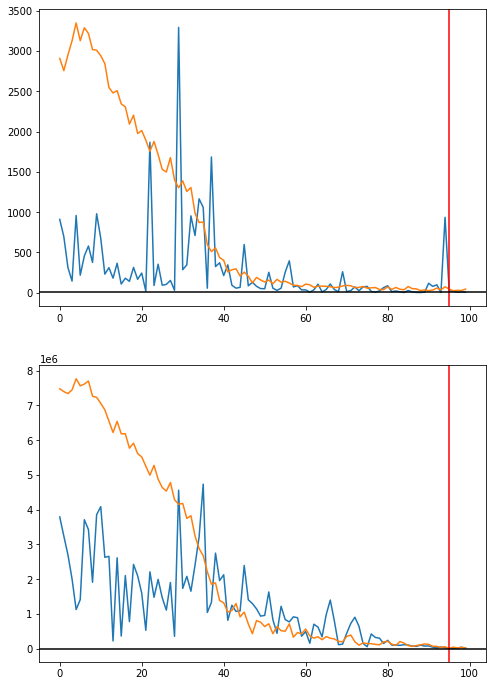

In [27]:
fig, axes = plt.subplots(2,1,figsize = (8,12))

axes[0].plot(df_history['epoch'], df_history['train_loss'])
axes[0].plot(df_history['epoch'], df_history['test_loss'])
axes[0].axvline(x = check_epoch, ymin = 0, ymax = df_history['test_loss'].max(), color = 'r')
axes[0].axhline(y = default_loss, xmin = 0, xmax = df_history['epoch'].max(), color = 'k')

axes[1].plot(df_history['epoch'], df_history['train_meas'])
axes[1].plot(df_history['epoch'], df_history['test_meas'])
axes[1].axvline(x = check_epoch, ymin = 0, ymax = df_history['test_meas'].max(), color = 'r')
axes[1].axhline(y = default_meas, xmin = 0, xmax = df_history['epoch'].max(), color = 'k')

In [28]:
model.load_state_dict(torch.load(checkpoint_path))
torch.save(model.state_dict(), model_path)

# Submission

In [29]:
# Load submission sample
submission = pd.read_csv("../input/google-smartphone-decimeter-challenge/sample_submission.csv")

In [30]:
model = SimpleNetwork(X.shape[1], y.shape[1])

model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [31]:
X, _ = extract_features(test_df, train = False)

X = torch.Tensor(X)

loader_test = DataLoader(X, batch_size = batch_size, shuffle = False)

model.eval()  # 신경망을 추론 모드로 전환

# 데이터로더에서 미니배치를 하나씩 꺼내 추론을 수행
predict = []
with torch.no_grad():  # 추론 과정에는 미분이 필요없음
    for data in loader_test:

        outputs = model(data)  # 데이터를 입력하고 출력을 계산
        predict.append(outputs)
predict = torch.cat(predict, axis = 0)

In [32]:
predict.shape

torch.Size([91486, 3])

In [33]:
submission.shape
submission.columns

Index(['phone', 'millisSinceGpsEpoch', 'latDeg', 'lngDeg'], dtype='object')

In [34]:
submission['latDeg'] = predict[:,1]
submission['lngDeg'] = predict[:,2]

In [35]:
submission.to_csv(f"./models/{notebookName}/{num_files} - result.csv", index = False)
pd.DataFrame([]).to_csv(dummy_path)